In [1]:
!pip install Quandl
!pip install investpy
!pip install missingno
!pip install pandas_ta

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import quandl
import investpy
import pandas_ta as ta

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Utils

In [3]:
URL_array  = set()
def link2df(URL,col_name,join_df,join=True,check_column=True,check_URL = True,clear_URL_array=False,show_details=False):
    '''This function scraps the given link and returns dataframe
    __________
    Parameters:
        URL(string): URL to be scrapped from bitcoin website
        col_name(string): column name for dataframe
        join_df(variable)= dataframe withwhich output dataframe will be left joined on Date
        join(boolean)= iF True,join, else don't join
        check_column(boolean)= check if column name already exists
        check_URL(boolean)= check if URL is already processed
        clear_URL_array(boolean)= if true URL_processed array will be cleared
        show_details(boolean)= various details wil be printed such as scrapping first and last details, df head & df tail     
        '''
        
    print(f'processing {col_name}')

    #clear URL append array
    if clear_URL_array==True:
        URL_array.clear()

    #set join parameters if false
    if join == False:
        join_df = None
        check_column=False

    #process column name by making it lowercase and replacing spaces,commas, full stops
    col_name = col_name.lower().replace(',','').replace(" ", "_").replace(".", "_")

    #col_name validation if exists already
    if check_column==True and col_name in list(join_df.columns):
        print(f'column {col_name} already esists in dataframe, stopped here')
        return join_df

    #URL validation if processes already
    elif check_URL==True and URL in list(URL_array):
        print(f'{URL} is already processed, stopped here')
        return join_df 

    #web scrapping
    page = requests.get(URL)
    soup = page.content
    soup = str(soup)
    scraped_output = (soup.split('[[')[1]).split('{labels')[0][0:-2]
    if show_details == True:
        print('head')
        print({scraped_output[0:30]})
        print('tail')
        print({scraped_output[-30:]})

    processed_str = scraped_output.replace('new Date(','')
    processed_str = processed_str.replace(')','')
    processed_str = processed_str.replace('[','')
    processed_str = processed_str.replace(']','')
    processed_str = processed_str.replace('"','')

    processed_str_list = processed_str.split(',')
    date_list,data_list = processed_str_list[::2],processed_str_list[1::2]

    #validate column lengths
    if len(date_list)!=len(data_list):
        print(f'date & data length:{len(date_list),len(data_list),len(date_list)==len(data_list)}')

    #convert list data to a dataframe
    if join == False:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'df shape{df.shape}')
            print('='*100)
            
        return df

    elif col_name not in list(join_df.columns) and join == True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        join_df = pd.merge(join_df,df,on=['Date'],how='left')
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'output df shape= {df.shape},joined_df shape = {join_df.shape}')
            print('='*100)
            print(f'Number of duplicate columns in dataframe {df.columns.duplicated().sum()}')
            print('='*100)
    
        return join_df

# Web scrapping 

### Price

In [4]:
final_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/04/2013',to_date='19/04/2021')
final_df = final_df.reset_index()
final_df.drop(['Currency','Volume'],inplace=True,axis=1)
final_df.columns = ['Date','opening_price','highest_price','lowest_price','closing_price']
final_df

,Date,opening_price,highest_price,lowest_price,closing_price
0,2013-04-01,93.0,106.0,92.2,104.0
1,2013-04-02,104.0,118.4,99.0,118.0
2,2013-04-03,118.0,147.0,110.0,135.0
3,2013-04-04,135.0,142.1,116.4,132.1
4,2013-04-05,132.1,144.9,130.2,142.3
...,...,...,...,...,...
2936,2021-04-15,62978.6,63729.1,62067.5,63216.0
2937,2021-04-16,63211.6,63518.5,60027.3,61379.7
2938,2021-04-17,61358.3,62509.1,59672.1,60041.9
2939,2021-04-18,60043.2,60362.1,51817.6,56207.1


In [5]:
### Number of transactions in blockchain per day 
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-transactions.html',
                   'transactions in blockchain',join_df=final_df,join=True)
### Average block size
final_df = link2df('https://bitinfocharts.com/comparison/size-btc.html',
                   'avg block size',join_df=final_df,join=True)
### Number of unique (from) adresses per day
final_df = link2df('https://bitinfocharts.com/comparison/sentbyaddress-btc.html',
                   'sent by adress',join_df=final_df,join=True)
### Average mining difficulty per day
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
                   'avg mining difficulty',join_df=final_df,join=True)
### Average hashrate (hash/s) per day
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
                   'avg hashrate',join_df=final_df,join=True)
### Mining Profitability USD/Day for 1 Hash/s
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html',
                   'mining profitability',join_df=final_df,join=True)
### Sent coins in USD per day
final_df = link2df('https://bitinfocharts.com/comparison/sentinusd-btc.html',
                   'Sent coins in USD',join_df=final_df,join=True)
### Average transaction fee, USD
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
                   'avg transaction fees',join_df=final_df,join=True)
### Median transaction fee, USD
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
                   'median transaction fees',join_df=final_df,join=True)
### Average block time (minutes)
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html',
                   'avg block time',join_df=final_df,join=True)
### Avg. Transaction Value, USD
final_df = link2df('https://bitinfocharts.com/comparison/transactionvalue-btc.html',
                   'avg transaction value',join_df=final_df,join=True)
### Median Transaction Value, USD
final_df = link2df('https://bitinfocharts.com/comparison/mediantransactionvalue-btc.html',
                   'median transaction value',join_df=final_df,join=True)
### Tweets per day
final_df = link2df('https://bitinfocharts.com/comparison/tweets-btc.html',
                   'tweets',join_df=final_df,join=True)
### Google Trends to "Bitcoin" @ 2012-01-01
final_df = link2df('https://bitinfocharts.com/comparison/google_trends-btc.html',
                   'google trends',join_df=final_df,join=True)
### Number of unique (from or to) addresses per day
final_df = link2df('https://bitinfocharts.com/comparison/activeaddresses-btc.html',
                   'active addresses',join_df=final_df,join=True)
### Top 100 Richest Addresses to Total coins %
final_df = link2df('https://bitinfocharts.com/comparison/top100cap-btc.html',
                   'top100 to total percentage',join_df=final_df,join=True)
### Average Fee Percentage in Total Block Reward
final_df = link2df('https://bitinfocharts.com/comparison/fee_to_reward-btc.html',
                   'avg fee to reward',join_df=final_df,join=True)
### Total number of bitcoins in circulation
btc_in_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_in_circulation_df = btc_in_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})
### Bitcoin Miners Revenue
miners_revenue_df = quandl.get("BCHAIN/MIREV",authtoken='9ztFCcK4_e1xGo_gjzK7')
miners_revenue_df = miners_revenue_df.rename(columns={'Value': 'miner_revenue'})

final_df['next_day_closing_price'] = final_df['closing_price'].shift(-1)

#Filtering data as we are considering this peiod only
final_df = final_df[np.logical_and(final_df['Date'] >= '01/04/2013',final_df['Date'] <= '20/04/2020')].reset_index(drop=True)

final_df = pd.merge(final_df,btc_in_circulation_df,on=['Date'],how='left')
final_df = pd.merge(final_df,miners_revenue_df,on=['Date'],how='left')

# Change the index to Date
final_df = final_df.set_index("Date")

processing transactions in blockchain
processing avg block size
processing sent by adress
processing avg mining difficulty
processing avg hashrate
processing mining profitability
processing Sent coins in USD
processing avg transaction fees
processing median transaction fees
processing avg block time
processing avg transaction value
processing median transaction value
processing tweets
processing google trends
processing active addresses
processing top100 to total percentage
processing avg fee to reward


# Fill NaN values

In [6]:
# replace null value to nan
final_df.replace(to_replace='null', value=np.nan,inplace=True)
final_df.drop(final_df.tail(1).index,inplace=True)

# Check NaN values
print(f"There is {final_df.isnull().values.sum()} NaN values")

There is 456 NaN values


In [7]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
tweets,428
active_addresses,21
top100_to_total_percentage,6
avg_block_time,1
opening_price,0
highest_price,0
number_of_coins_in_circulation,0
next_day_closing_price,0
avg_fee_to_reward,0
google_trends,0


### Remove NaN values in tweets

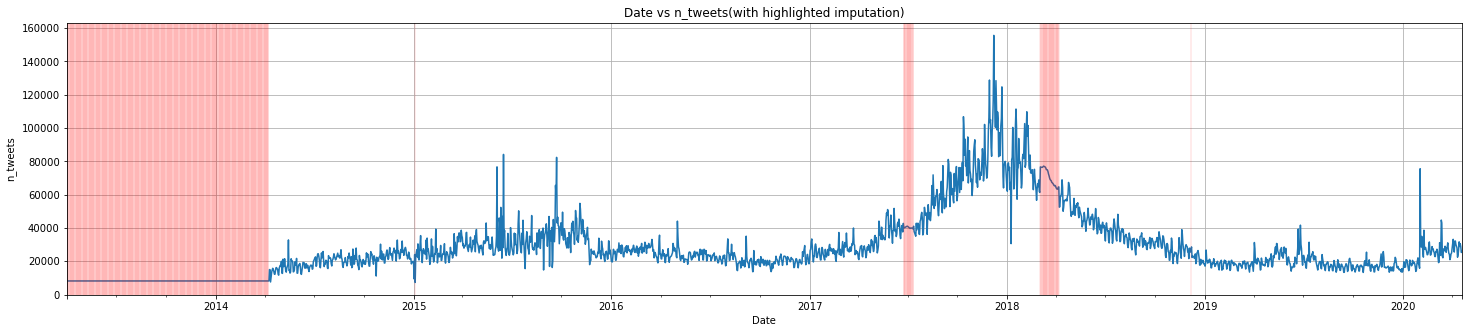

In [8]:
final_df['tweets'].fillna(final_df['tweets'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df.index.values,y='tweets',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['tweets']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('n_tweets')
plt.title('Date vs n_tweets(with highlighted imputation)')
plt.show()
final_df['tweets'] = final_df['tweets'].fillna(final_df['tweets'].rolling(40, min_periods=1).mean()).bfill()

### Remove NaN values in active_addresses

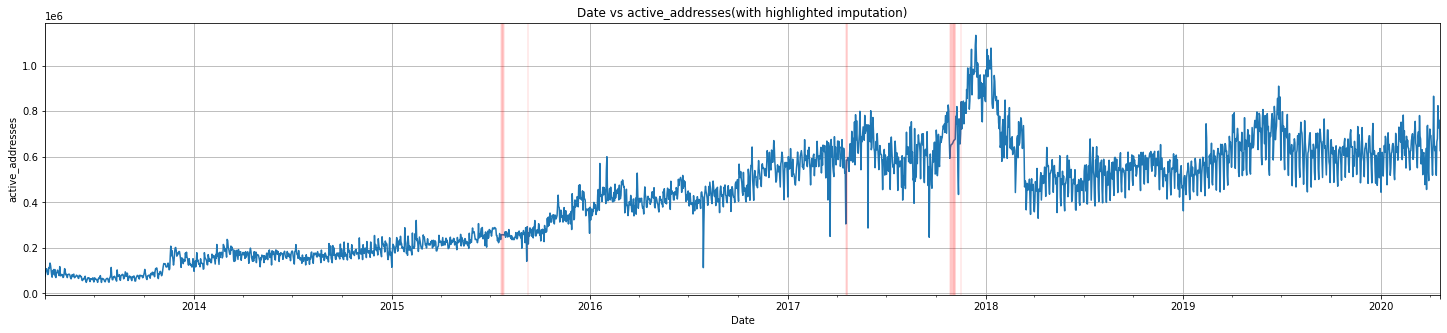

In [9]:
final_df['active_addresses'].fillna(final_df['active_addresses'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df.index.values,y='active_addresses',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['active_addresses']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('active_addresses')
plt.title('Date vs active_addresses(with highlighted imputation)')
plt.show()
final_df['active_addresses'] = final_df['active_addresses'].fillna(final_df['active_addresses'].rolling(40, min_periods=1).mean()).bfill()

### Remove NaN values in top100_to_total_percentage

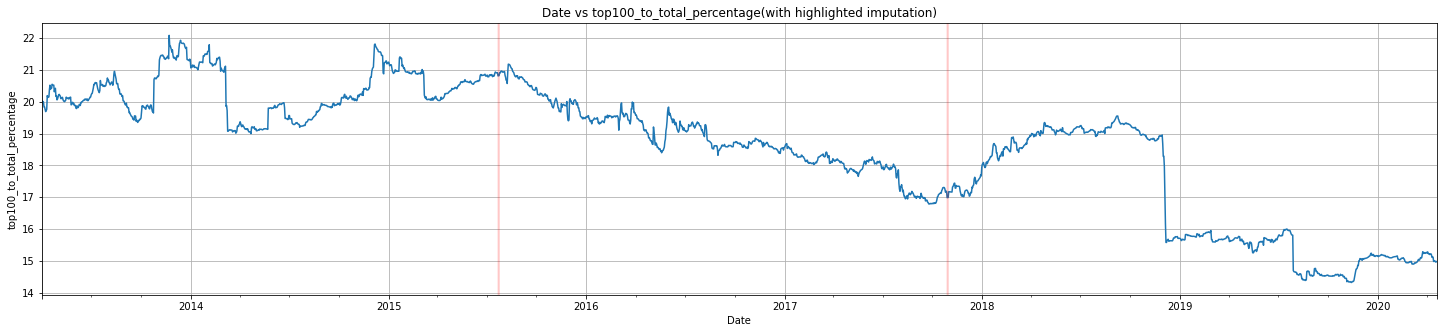

In [10]:
final_df['top100_to_total_percentage'].fillna(final_df['top100_to_total_percentage'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df.index.values,y='top100_to_total_percentage',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['top100_to_total_percentage']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('top100_to_total_percentage')
plt.title('Date vs top100_to_total_percentage(with highlighted imputation)')
plt.show()
final_df['top100_to_total_percentage'] = final_df['top100_to_total_percentage'].fillna(final_df['top100_to_total_percentage'].rolling(40, min_periods=1).mean()).bfill()

### Remove NaN values in avg_block_time

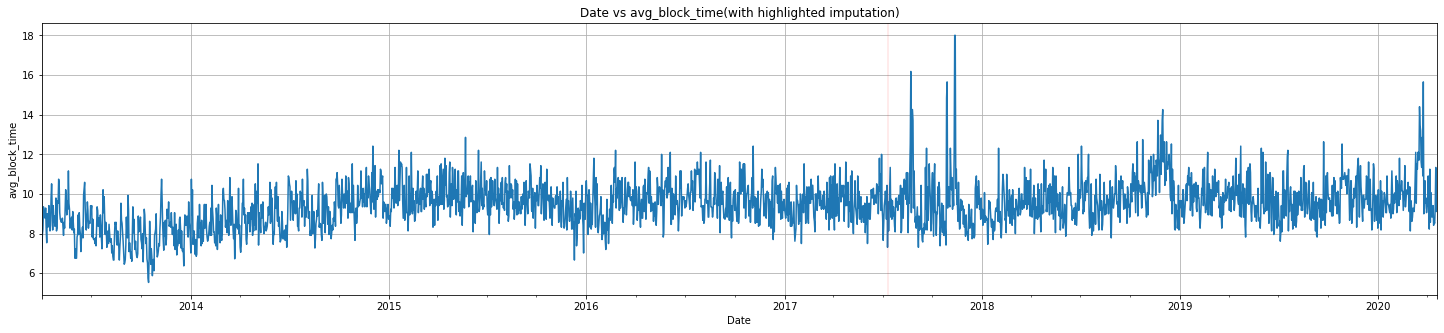

In [11]:
final_df['avg_block_time'].fillna(final_df['avg_block_time'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df.index.values,y='avg_block_time',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['avg_block_time']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('avg_block_time')
plt.title('Date vs avg_block_time(with highlighted imputation)')
plt.show()
final_df['avg_block_time'] = final_df['avg_block_time'].fillna(final_df['avg_block_time'].rolling(40, min_periods=1).mean()).bfill()

### Remarks

We fill the NaN values by using a rolling mean on 40 days. 

In [12]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
opening_price,0
highest_price,0
number_of_coins_in_circulation,0
next_day_closing_price,0
avg_fee_to_reward,0
top100_to_total_percentage,0
active_addresses,0
google_trends,0
tweets,0
median_transaction_value,0


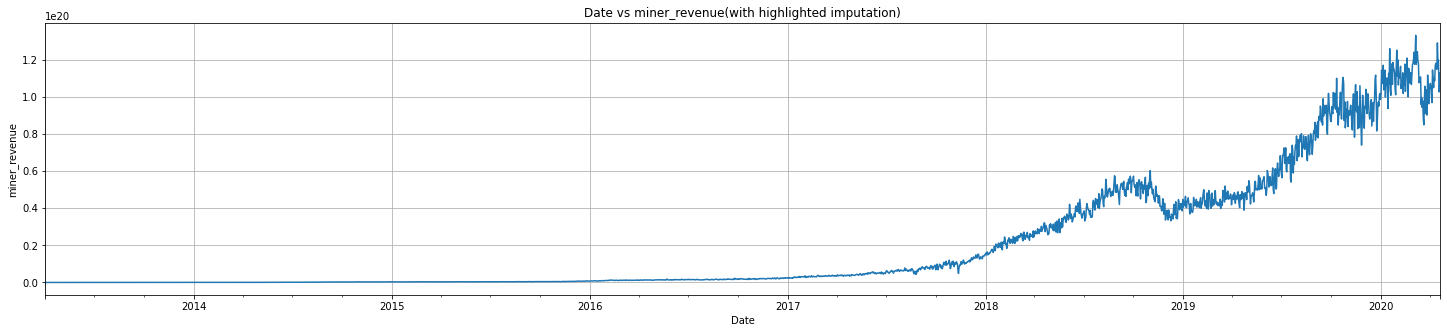

In [13]:
final_df['avg_hashrate'].fillna(final_df['avg_hashrate'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=final_df.index.values,y='avg_hashrate',figsize=(25,5),grid=True) 
plt.ylabel('miner_revenue')
plt.title('Date vs miner_revenue(with highlighted imputation)')
plt.show()

# Features 

In [14]:
final_df.dtypes

opening_price                     float64
highest_price                     float64
lowest_price                      float64
closing_price                     float64
transactions_in_blockchain         object
avg_block_size                     object
sent_by_adress                     object
avg_mining_difficulty              object
avg_hashrate                       object
mining_profitability               object
sent_coins_in_usd                  object
avg_transaction_fees               object
median_transaction_fees            object
avg_block_time                     object
avg_transaction_value              object
median_transaction_value           object
tweets                             object
google_trends                      object
active_addresses                   object
top100_to_total_percentage         object
avg_fee_to_reward                  object
next_day_closing_price            float64
number_of_coins_in_circulation    float64
miner_revenue                     

In [15]:
# put all values to type "float"
final_df = final_df.astype("float")

In [16]:
def feature_smoothening(df,feature_name,smoothening_type,smoothening_range=[7,30,90],show_plot=False,show_original_Feature_in_plot=True):
    if smoothening_type == 'sma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j) 

    elif smoothening_type == 'var':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.variance(df[feature_name],j)

    elif smoothening_type == 'stdev':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.stdev(df[feature_name],j)
    
    elif smoothening_type == 'ema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.ema(df[feature_name],j)

    elif smoothening_type == 'wma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.wma(df[feature_name],j)

    elif smoothening_type == 'rsi':
        for j in smoothening_range:
             df[f'{smoothening_type}{j} {feature_name}'] = ta.rsi(df[feature_name],j)

    elif smoothening_type == 'roc':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.roc(df[feature_name],j)  

    elif smoothening_type == 'dema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.dema(df[feature_name],j) 

    elif smoothening_type == 'tema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.tema(df[feature_name],j) 

    elif smoothening_type == 'bband_lower':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBL_{j}_2.0']

    elif smoothening_type == 'bband_upper':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBU_{j}_2.0']

    elif smoothening_type == 'macd':
        macd_df = ta.macd(df[feature_name])
        df[f'{smoothening_type} hist {feature_name}'] = macd_df['MACDh_12_26_9']
        df[f'{smoothening_type} signal {feature_name}'] = macd_df['MACDs_12_26_9']
        df[f'{smoothening_type} {feature_name}'] = macd_df['MACD_12_26_9']

    
    if show_plot == True and show_original_Feature_in_plot==True :
        df[[feature_name]+[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Smoothening-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

    elif show_plot == True and show_original_Feature_in_plot==False :
        df[[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Smoothening-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

In [17]:
feature_list = [i for i in list(final_df.columns) if i not in ['Date','next_day_closing_price']]
for feature in feature_list:
    feature_smoothening(final_df,feature,'sma')
    feature_smoothening(final_df,feature,'var')
    feature_smoothening(final_df,feature,'stdev')
    feature_smoothening(final_df,feature,'ema')
    feature_smoothening(final_df,feature,'wma')
    feature_smoothening(final_df,feature,'rsi')
    feature_smoothening(final_df,feature,'roc')
    feature_smoothening(final_df,feature,'dema')
    feature_smoothening(final_df,feature,'tema')
    feature_smoothening(final_df,feature,'bband_lower')
    feature_smoothening(final_df,feature,'bband_upper')
    feature_smoothening(final_df,feature,'macd')

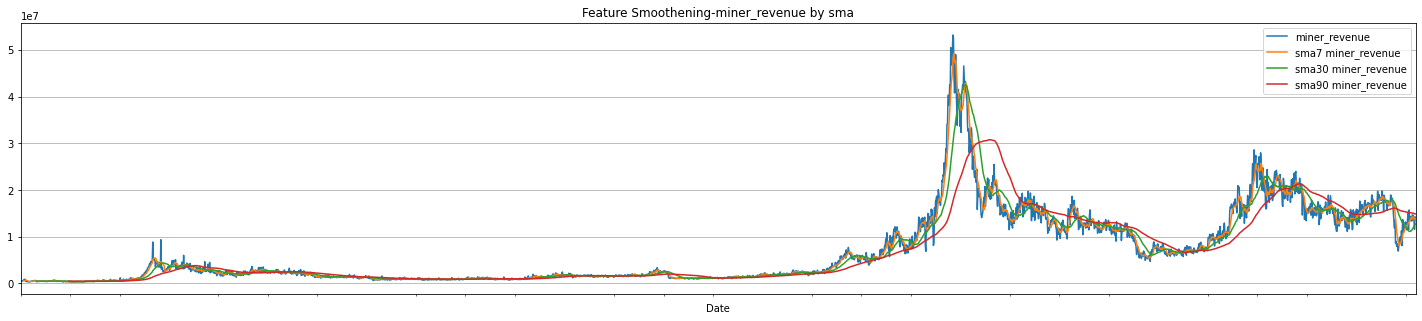

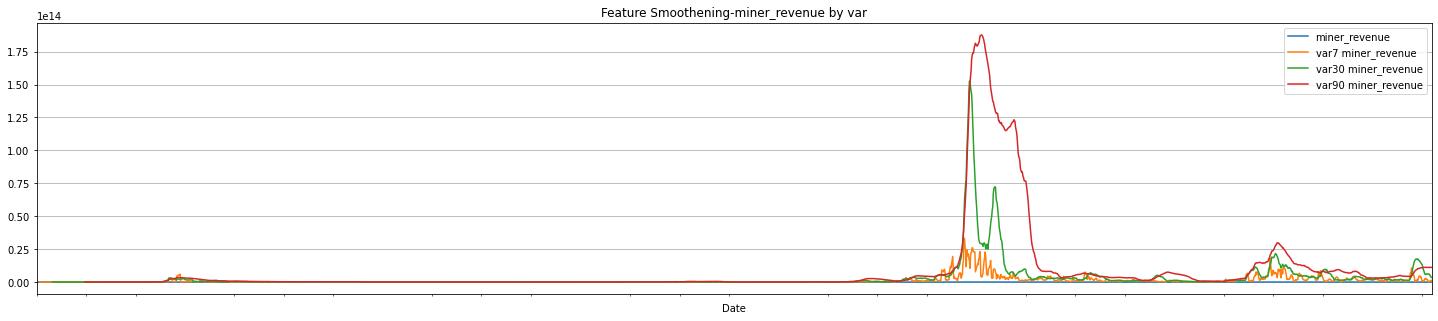

In [18]:
feature_smoothening(final_df,feature,'sma',show_plot=True)
feature_smoothening(final_df,feature,'var',show_plot=True)

# Test of stationarity 

In [19]:
# Load Statsmodels 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [20]:
# ADF Test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(final_df["closing_price"])

Results of Dickey-Fuller Test:
Test Statistic                   -1.697262
p-value                           0.432524
#Lags Used                       27.000000
Number of Observations Used    2548.000000
Critical Value (1%)              -3.432919
Critical Value (5%)              -2.862675
Critical Value (10%)             -2.567374
dtype: float64


The Augmented Dickey Test (ADF test)is one of the most common statistical tests used to test the stationarity of a given Time Series. It's a unit root test. 

Here, we observe the same order of magnitude for the ADF statistic -1.697262 with a p-value p = 0.43. The Time Series has then a  unit root and a trend.

# Pre-processing

In [21]:
final_df = final_df.interpolate(method='linear', axis=1)
check_for_nan = final_df.isnull().values.any()
check_for_nan

False

## Nan Values filling for the features 

In [22]:
#missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
#index_with_nan = missing_values[missing_values>0].index[missing_values[missing_values>0].isnull().any(axis=1)]
#missing_values.drop(index_with_nan,0, inplace=True)

#final_df[missing_values.index] = final_df[missing_values.index].fillna(final_df[missing_values[missing_values>0].index].rolling(40, min_periods=1).mean()).bfill()

In [23]:
# We create a column class as in the article 
# if P_btc[t+1]-P_btc[t] >=0 --> y[t] = +1 otherwise y[t]=0

final_df["class"] = (np.sign(final_df["closing_price"] - final_df["closing_price"].shift()) + 1)//2
final_df["class"][0] = 1 # otherwise, it's a NaN value

## Create train and test data

In [24]:
data = final_df.drop(["class","next_day_closing_price"],axis = 1)
Y_regression = final_df["next_day_closing_price"]
Y_classification = final_df['class']
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(data,Y_classification,test_size=0.2, shuffle=False, random_state=7)
X_train_reg, X_test_reg , Y_train_reg, Y_test_reg = train_test_split(data,Y_regression,test_size=0.2, shuffle=True, random_state=7)

In [25]:
data.shape, X_train_reg.shape

((2576, 851), (2060, 851))

In [26]:
scaler = RobustScaler()
X_scaled = data.copy()
X_scaled= scaler.fit_transform(X_train_reg)

scaler = MinMaxScaler()
X_scaled =  scaler.fit_transform(X_scaled)

rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=1)
rf.fit(X_scaled,Y_train_reg)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.3s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100building tree 81 of 100

building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100building tree 88 of 100

building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished


RandomForestRegressor(n_jobs=-1, random_state=1, verbose=5)

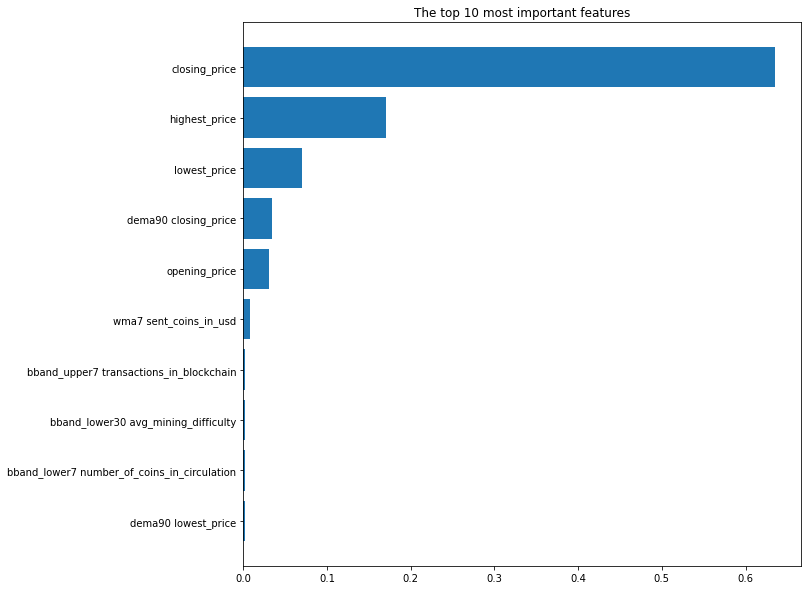

In [27]:
plt.figure(figsize=(10,10))
plt.title("The top 10 most important features")
f_i = list(zip(final_df.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i[-10:]],[x[1] for x in f_i[-10:]])

plt.show()

# Data visualisation 

## Lag plot

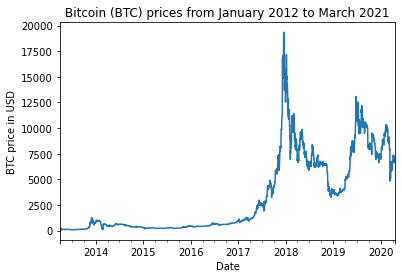

In [28]:
final_df["closing_price"].plot()
plt.title("Bitcoin (BTC) prices from January 2012 to March 2021")
plt.xlabel("Date")
plt.ylabel("BTC price in USD")
plt.show()

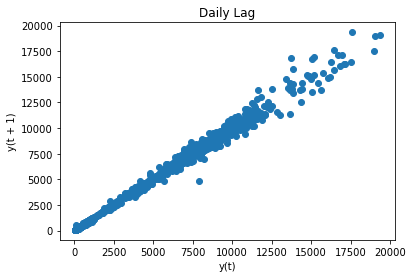

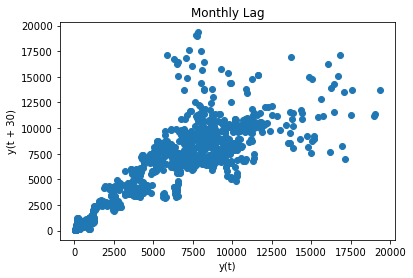

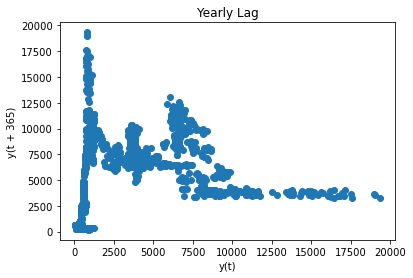

In [29]:
plt.title('Daily Lag')
pd.plotting.lag_plot(final_df["closing_price"], lag = 1)
plt.show()

plt.title('Monthly Lag')
pd.plotting.lag_plot(final_df["closing_price"], lag = 30)
plt.show()

plt.title('Yearly Lag')
pd.plotting.lag_plot(final_df["closing_price"], lag = 365)
plt.show()

Thanks to lag plots, one can observethe autocorrelation of the data. The data shows a correlation for daily lag plots. For monthly lag plots, it seems that there is no correlation around 2017 when the price of bitcoin skyrocketed.Concerning, the yearly lag plots, there is no correlation at all.

# PCA

In [30]:
from sklearn.decomposition import PCA

In [31]:
df_centered_cl = X_train_class.apply(lambda x: x-x.mean())
df_centered_reg = X_train_reg.apply(lambda x: x-x.mean())

pca_class = PCA(n_components=0.95, svd_solver='full')
pca_reg = PCA(n_components=0.95, svd_solver='full')
pca_class.fit(df_centered_cl)
pca_reg.fit(df_centered_reg)

PCA(n_components=0.95, svd_solver='full')

In [32]:
#we create the new data set
X_train_class_pca = pca_class.transform(df_centered_cl)
X_train_reg_pca = pca_reg.transform(df_centered_reg)
X_test_class_pca = pca_class.transform( X_test_class.apply(lambda x: x-x.mean()) )
X_test_reg_pca = pca_reg.transform( X_test_reg.apply(lambda x: x-x.mean()) )

# RF method 

In [33]:
f_i.sort(key = lambda x : x[1], reverse=True)
col_kept = 10
col_RF = []
for i in range(col_kept):
    col_RF.append( f_i[i][0])
col_RF

['closing_price',
 'highest_price',
 'lowest_price',
 'dema90 closing_price',
 'opening_price',
 'wma7 sent_coins_in_usd',
 'bband_upper7 transactions_in_blockchain',
 'bband_lower30 avg_mining_difficulty',
 'bband_lower7 number_of_coins_in_circulation',
 'dema90 lowest_price']

In [34]:
X_train_class_rf = X_train_class[ col_RF ]
X_test_class_rf = X_test_class[ col_RF ]

X_train_reg_rf = X_train_reg[ col_RF ]
X_test_reg_rf = X_test_reg[ col_RF ]

# Test for multicolinearity

### Pearson test

In [35]:
ten_most_important_features = [x[0] for x in f_i[-10:]]
correlation = final_df.corr()
correlation.loc[ten_most_important_features][ten_most_important_features]

,roc30 avg_hashrate,macd hist mining_profitability,rsi7 sent_coins_in_usd,sma90 top100_to_total_percentage,roc7 avg_hashrate,bband_upper90 mining_profitability,wma90 avg_hashrate,rsi30 avg_hashrate,rsi90 avg_hashrate,rsi90 number_of_coins_in_circulation
roc30 avg_hashrate,1.000000,0.832540,0.475274,-0.004494,0.475315,0.832543,-0.059206,0.475315,0.475315,0.471152
macd hist mining_profitability,0.832540,1.000000,0.226792,-0.000950,0.226803,0.999999,-0.054530,0.226803,0.226803,0.224954
rsi7 sent_coins_in_usd,0.475274,0.226792,1.000000,0.006206,0.999974,0.226802,-0.012807,0.999974,0.999974,0.993194
sma90 top100_to_total_percentage,-0.004494,-0.000950,0.006206,1.000000,-0.000956,0.000638,-0.030746,-0.000956,-0.000956,0.122637
roc7 avg_hashrate,0.475315,0.226803,0.999974,-0.000956,1.000000,0.226801,-0.012588,1.000000,1.000000,0.992334
bband_upper90 mining_profitability,0.832543,0.999999,0.226802,0.000638,0.226801,1.000000,-0.054620,0.226801,0.226801,0.225148
wma90 avg_hashrate,-0.059206,-0.054530,-0.012807,-0.030746,-0.012588,-0.054620,1.000000,-0.012588,-0.012588,-0.016272
rsi30 avg_hashrate,0.475315,0.226803,0.999974,-0.000956,1.000000,0.226801,-0.012588,1.000000,1.000000,0.992334
rsi90 avg_hashrate,0.475315,0.226803,0.999974,-0.000956,1.000000,0.226801,-0.012588,1.000000,1.000000,0.992334
rsi90 number_of_coins_in_circulation,0.471152,0.224954,0.993194,0.122637,0.992334,0.225148,-0.016272,0.992334,0.992334,1.000000


It seems that the features are mostly highly correlated

# AVEC LE TP

In [36]:
from itertools import tee

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.fft import rfft, rfftfreq
from scipy.cluster import hierarchy
from scipy.signal import argrelmax, stft
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, spearmanr, kurtosis, skew
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.stattools import acf

In [37]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

For a signal $x\in\mathbb{R}^N$ with $N$ samples, the autocorrelation with lag $m$ is defined as follows:

$$
\hat{\gamma}[m] := \frac{1}{N-|m|} \sum_{n=0}^{N-1} x[n]x[n+m].
$$

Note that if the signal $x$ is periodic, then the autocorrelation is also periodic with same period.

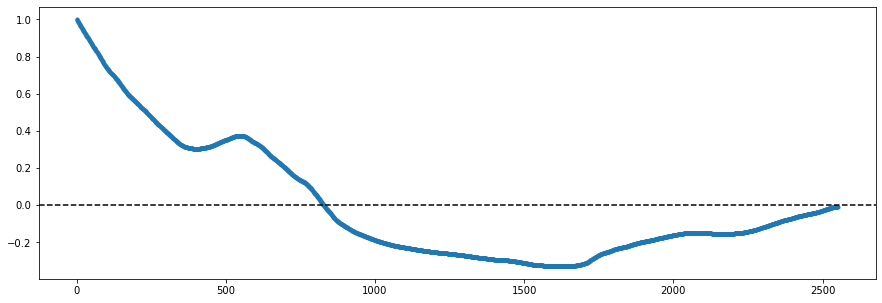

In [38]:
fig, ax = fig_ax()
ax.plot(acf(final_df["closing_price"], nlags=2550, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

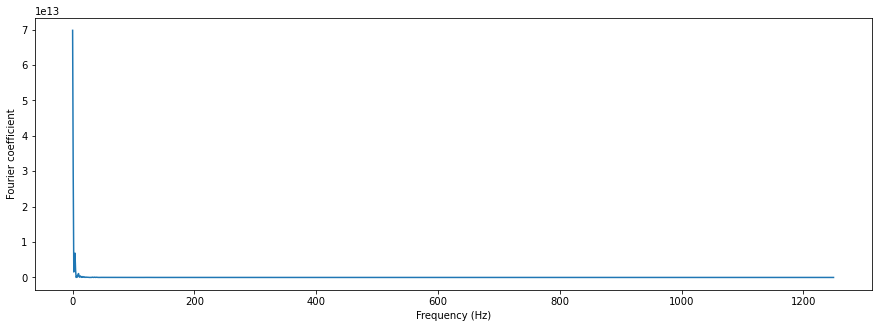

In [39]:
n_samples = 2577
FREQUENCY = 2500

fourier = abs(rfft(final_df["closing_price"])) ** 2
freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)

fig, ax = fig_ax()
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Fourier coefficient")

In [40]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def get_fourier_features(signal: np.ndarray, n_bins: int = 100) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""

    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)
    for (f_min, f_max) in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        res_dict[f"fourier_{f_min:.1f}-{f_max:.1f}_Hz"] = np.log(
            np.sum(fourier[keep] ** 2)
        )
    return res_dict

get_fourier_features(final_df["closing_price"], n_bins=10)

{'fourier_0.0-125.0_Hz': 32.399725305573575,
 'fourier_125.0-250.0_Hz': 25.5458646999281,
 'fourier_250.0-375.0_Hz': 24.67226809027471,
 'fourier_375.0-500.0_Hz': 23.93229414637993,
 'fourier_500.0-625.0_Hz': 23.69667780352132,
 'fourier_625.0-750.0_Hz': 23.115948930526958,
 'fourier_750.0-875.0_Hz': 22.767263537447754,
 'fourier_875.0-1000.0_Hz': 22.988290649442114,
 'fourier_1000.0-1125.0_Hz': 22.80026636200363,
 'fourier_1125.0-1250.0_Hz': 22.544781223030263}

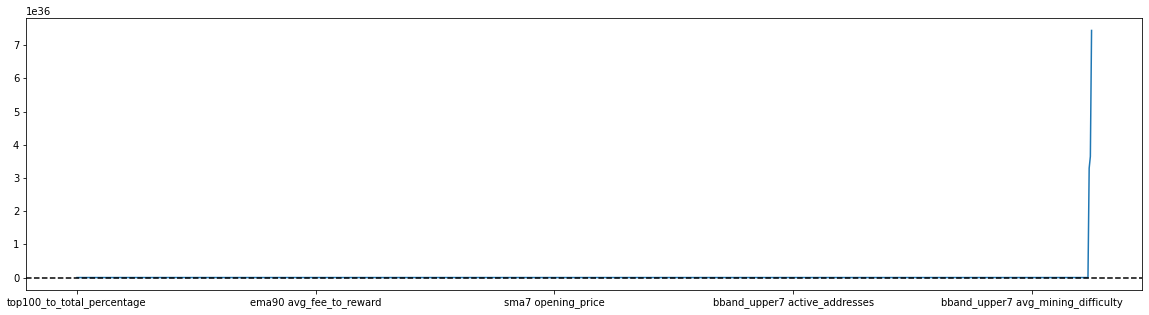

In [41]:
all_features = X_train_class

fig, ax = fig_ax(figsize=(20, 5))
all_features.std().sort_values().plot(ax=ax)

# change the height of the horizontal line here
ax.axhline(0.01, ls="--", color="k")

In [42]:
# Be careful when dropping low variance features, 
#they might still be informative. 
#Quickly check that it makes sense to drop them
variance_threshold = 0.05

In [43]:
low_variance_features = all_features.std() < variance_threshold
low_variance_features = low_variance_features[
    low_variance_features
].index.to_numpy()
print(f"There are {len(low_variance_features)} features to drop.")
print(low_variance_features)

There are 0 features to drop.
[]


In [44]:
# remove the low-variance features
all_features.drop(columns=low_variance_features, inplace=True, errors="ignore")
print(f"There are {all_features.shape[1]} features left.")


There are 851 features left.


# Check outliers 

<AxesSubplot:>

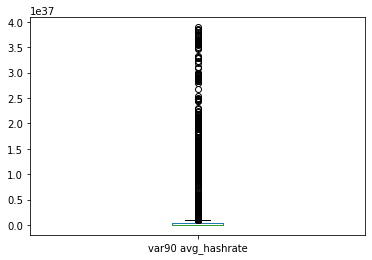

In [45]:
 all_features.std().sort_values()

feature_to_check = "var90 avg_hashrate"
all_features[feature_to_check].plot(kind="box")

In [46]:
all_features[feature_to_check][all_features[feature_to_check] > 700]


Date
2013-04-01    4.818914e+05
2013-04-02    5.312995e+05
2013-04-03    5.384239e+05
2013-04-04    5.251576e+05
2013-04-05    6.064548e+05
                  ...     
2018-11-16    1.494239e+37
2018-11-17    1.508577e+37
2018-11-18    1.506094e+37
2018-11-19    1.604121e+37
2018-11-20    1.695289e+37
Name: var90 avg_hashrate, Length: 2060, dtype: float64

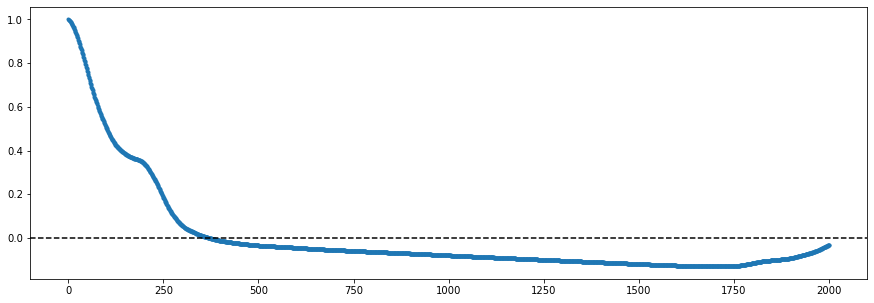

In [47]:
outlier = X_train_class["var90 avg_hashrate"]
fig, ax = fig_ax()
ax.plot(acf(outlier, nlags=2000, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

Multicollinearity

Multicollinearity degrades numerical stability and interpretability. Compute the rank-based Spearman correlation. Features with a correlation above a threshold are grouped together in a cluster. We then choose a single feature from each cluster.

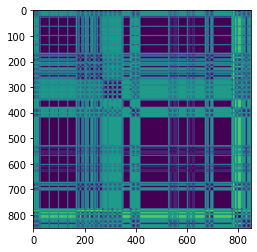

In [48]:
correlation_threshold = 0.8

corr = pdist(
    all_features.to_numpy().T, metric="correlation"
)  # distance matrix
plt.imshow(squareform(corr))

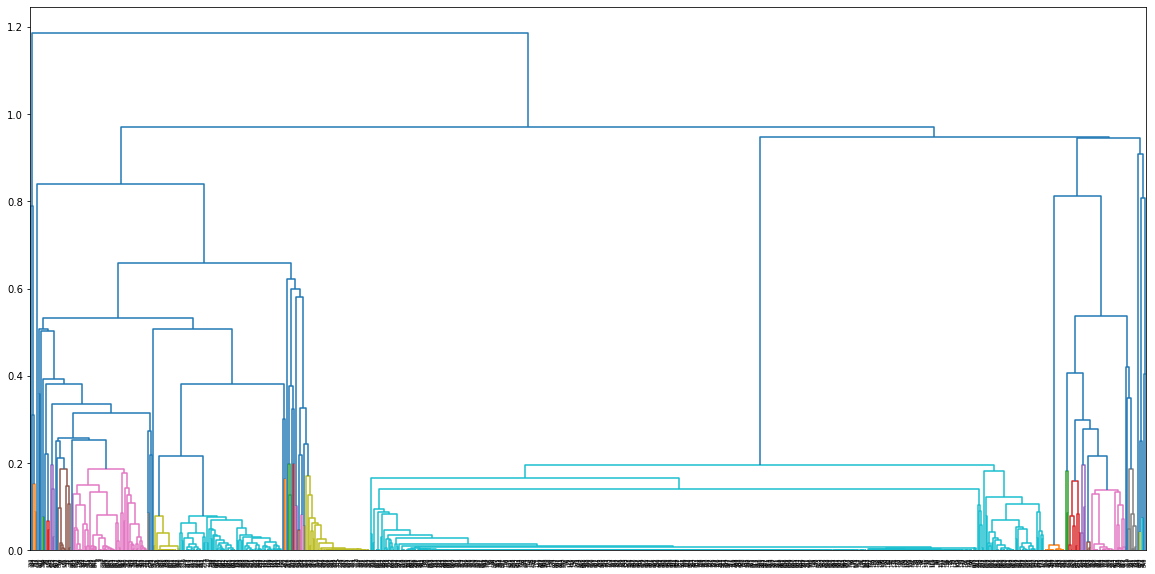

In [49]:
fig, ax = fig_ax((20, 10))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=1 - correlation_threshold
)

In [50]:
# compute the clusters
cluster_ids = hierarchy.fcluster(
    corr_linkage, 1 - correlation_threshold, criterion="distance"
)

# print the largest clusters
largest_cluster_ind = np.bincount(cluster_ids).argmax()
print(
    f"The largest cluster is {all_features.columns[cluster_ids==largest_cluster_ind].tolist()}."
)

# for each cluster, only keep the first feature
keep_features = list()
for cluster in np.unique(cluster_ids):
    cluster_indexes = np.where(cluster_ids == cluster)[0]
    keep_features.append(all_features.columns[cluster_indexes[0]])

# Reduce the number of features
all_features = all_features[keep_features]

The largest cluster is ['sma7 opening_price', 'sma30 opening_price', 'sma90 opening_price', 'stdev7 opening_price', 'stdev30 opening_price', 'stdev90 opening_price', 'ema7 opening_price', 'ema30 opening_price', 'ema90 opening_price', 'wma7 opening_price', 'wma30 opening_price', 'wma90 opening_price', 'rsi7 opening_price', 'rsi30 opening_price', 'rsi90 opening_price', 'roc7 opening_price', 'roc30 opening_price', 'roc90 opening_price', 'dema7 opening_price', 'dema30 opening_price', 'dema90 opening_price', 'tema7 opening_price', 'tema30 opening_price', 'tema90 opening_price', 'bband_lower7 opening_price', 'bband_lower30 opening_price', 'bband_lower90 opening_price', 'bband_upper7 opening_price', 'bband_upper30 opening_price', 'bband_upper90 opening_price', 'macd hist opening_price', 'macd signal opening_price', 'macd opening_price', 'sma7 highest_price', 'sma30 highest_price', 'sma90 highest_price', 'stdev7 highest_price', 'stdev30 highest_price', 'stdev90 highest_price', 'ema7 highest_pr

In [51]:
labels = final_df["class"][X_train_class.index]

In [52]:
from sklearn.feature_selection import RFE
# Let's try with a random forest
rf = RandomForestClassifier()
sfs = RFE(
    rf, n_features_to_select=20,
)
sfs.fit(all_features, labels)

print("Selected features:")
print(all_features.columns[sfs.get_support()].tolist())

Selected features:
['var7 number_of_coins_in_circulation', 'top100_to_total_percentage', 'var7 avg_transaction_value', 'var7 opening_price', 'var30 median_transaction_value', 'opening_price', 'var30 transactions_in_blockchain', 'transactions_in_blockchain', 'var7 transactions_in_blockchain', 'avg_fee_to_reward', 'stdev7 avg_block_size', 'var30 avg_block_size', 'avg_block_time', 'macd hist sent_by_adress', 'var30 mining_profitability', 'macd signal miner_revenue', 'macd signal sent_coins_in_usd', 'macd hist sent_coins_in_usd', 'macd hist miner_revenue', 'macd hist avg_hashrate']


In [53]:
rf = RandomForestClassifier().fit(all_features, labels)
list(all_features.columns[np.flip(np.argsort(rf.feature_importances_))])

['macd hist miner_revenue',
 'transactions_in_blockchain',
 'macd hist sent_by_adress',
 'var7 opening_price',
 'macd hist avg_hashrate',
 'avg_block_time',
 'opening_price',
 'var7 number_of_coins_in_circulation',
 'avg_fee_to_reward',
 'var7 avg_block_size',
 'var7 transactions_in_blockchain',
 'var7 avg_transaction_value',
 'var30 avg_block_size',
 'macd hist sent_coins_in_usd',
 'stdev7 avg_block_size',
 'macd signal miner_revenue',
 'var30 transactions_in_blockchain',
 'var7 active_addresses',
 'var7 lowest_price',
 'macd signal sent_coins_in_usd',
 'mining_profitability',
 'var30 active_addresses',
 'top100_to_total_percentage',
 'bband_upper30 sent_by_adress',
 'macd signal avg_hashrate',
 'var7 tweets',
 'bband_lower30 sent_coins_in_usd',
 'var30 median_transaction_value',
 'var30 avg_transaction_value',
 'var90 transactions_in_blockchain',
 'var90 mining_profitability',
 'var30 mining_profitability',
 'var7 sent_coins_in_usd',
 'avg_transaction_fees',
 'tweets',
 'bband_lower9

# ANN Classification

In [ ]:
from tensorflow import keras

In [ ]:
!pip install keras.utils

In [ ]:
from keras import *
from keras.callbacks import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from keras.layers import *
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.vis_utils import plot_model


In [ ]:
from keras.optimizer_v2.adam import Adam as Adam

### PCA

In [ ]:
estimators=[]
estimators.append(['robust',RobustScaler()])
estimators.append(['mixmax',MinMaxScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train_class_pca)
X_train_class_pca=scale.transform(X_train_class_pca)
X_test_class_pca=scale.transform(X_test_class_pca)

shape = X_train_class_pca.shape[1]

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    #lr = 1e-2
    lr = 0.008
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# define neural network model
def sequential_model(initializer='normal', activation='relu', neurons=300, NUM_FEATURES=shape):
    # create model
    model = Sequential()
    model.add(Dense(400, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(500, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(2, activation='softmax', kernel_initializer=initializer))
    # Compile model
    adam=Adam(lr=lr_schedule(0),amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    #model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.compile(loss='logcosh', optimizer=adam, metrics=['accuracy'])
    return model

#mcp_save = ModelCheckpoint('trained_models/ANN_cls_interval3_pca.hdf5', save_best_only=True, monitor='val_loss', mode='max')
#earlyStopping = EarlyStopping(monitor='val_loss', patience=100,verbose=1, mode='max')
classifier=KerasClassifier(build_fn=sequential_model,batch_size=64, epochs=1000,validation_split=0.1,validation_freq=1, shuffle=True,use_multiprocessing=True)#, callbacks=[mcp_save,earlyStopping])

classifier.fit(X_train_class_pca,Y_train_class)

#prediction_model = load_model('trained_models/ANN_cls_interval3_pca.hdf5',compile=False)


In [ ]:
y_pred_pca=classifier.predict(X_test_class_pca)
print('Accuracy score : ', accuracy_score(Y_test_class,y_pred_pca) )
print( 'f1 score : ', f1_score(Y_test_class,y_pred_pca,average='binary'))
print( 'AUC : ', roc_auc_score(Y_test_class,y_pred_pca))
print(classification_report(Y_test_class,y_pred_pca,labels=[0,1], target_names=['decrease','increase']))

### RF

In [ ]:
estimators=[]
estimators.append(['robust',RobustScaler()])
estimators.append(['mixmax',MinMaxScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train_class_rf)
X_train_class_rf=scale.transform(X_train_class_rf)
X_test_class_rf=scale.transform(X_test_class_rf)

shape = X_train_class_rf.shape[1]

# define neural network model
def sequential_model(initializer='normal', activation='relu', neurons=300, NUM_FEATURES=shape):
    # create model
    model = Sequential()
    model.add(Dense(400, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(500, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(2, activation='softmax', kernel_initializer=initializer))
    # Compile model
    adam=Adam(lr=lr_schedule(0),amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['accuracy'])
    return model

mcp_save = ModelCheckpoint('trained_models/ANN_cls_interval3_pca.hdf5', save_best_only=True, monitor='val_loss', mode='max')
#earlyStopping = EarlyStopping(monitor='val_loss', patience=100,verbose=1, mode='max')
classifier=KerasClassifier(build_fn=sequential_model,batch_size=64, epochs=1000,validation_split=0.1,validation_freq=1, shuffle=True,use_multiprocessing=True)#, callbacks=[mcp_save,earlyStopping])

classifier.fit(X_train_class_rf,Y_train_class)

#prediction_model = load_model('trained_models/ANN_cls_interval3_pca.hdf5',compile=False)


In [ ]:
y_pred_rf=classifier.predict(X_test_class_rf)
print('Accuracy score : ', accuracy_score(Y_test_class,y_pred_rf) )
print( 'f1 score : ', f1_score(Y_test_class,y_pred_rf,average='binary'))
print( 'AUC : ', roc_auc_score(Y_test_class,y_pred_rf))
print(classification_report(Y_test_class,y_pred_rf,labels=[0,1], target_names=['decrease','increase']))

# ANN Regression


### PCA

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

shape = X_train_reg_pca.shape[1]

def sequential_model(initializer='normal', activation='relu', neurons=300, NUM_FEATURES=shape):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation=activation, kernel_initializer=initializer))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

regressor=KerasRegressor(build_fn=sequential_model, batch_size=64, epochs=1000,verbose=1, shuffle=True,
                         validation_split=0.1,validation_freq=1,
                        use_multiprocessing=True)#, callbacks=[mcp_save,earlyStopping])

regressor.fit(X_train_reg_pca,Y_train_reg)

In [ ]:
y_pred_pca=regressor.predict(X_test_reg_pca)
print( 'MAE : ', mean_absolute_error(Y_test_reg,y_pred_pca) )
print( 'MSE : ' , mean_squared_error(Y_test_reg,y_pred_pca) )
print( 'RMSE :', np.sqrt(mean_squared_error(Y_test_reg,y_pred_pca)) )
print( 'MAPE : ' , mean_absolute_percentage_error(Y_test_reg,y_pred_pca) )

### RF

In [ ]:
shape = X_train_reg_rf.shape[1]

def sequential_model(initializer='normal', activation='relu', neurons=300, NUM_FEATURES=shape):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation=activation, kernel_initializer=initializer))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

regressor=KerasRegressor(build_fn=sequential_model, batch_size=64, epochs=1000,verbose=1, shuffle=True,
                         validation_split=0.1,validation_freq=1,
                        use_multiprocessing=True)#, callbacks=[mcp_save,earlyStopping])

regressor.fit(X_train_reg_rf,Y_train_reg)

In [ ]:
y_pred_rf=regressor.predict(X_test_reg_rf)
print( 'MAE : ', mean_absolute_error(Y_test_reg,y_pred_rf) )
print( 'MSE : ' , mean_squared_error(Y_test_reg,y_pred_rf) )
print( 'RMSE :', np.sqrt(mean_squared_error(Y_test_reg,y_pred_rf)) )
print( 'MAPE : ' , mean_absolute_percentage_error(Y_test_reg,y_pred_rf) )

# SVM Classification

In [54]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

### PCA

In [55]:
svr_pca=SVC(kernel='sigmoid',C=1000,verbose=True)
svr_pca.fit(X_train_class_pca,Y_train_class)
svr_pca.score(X_train_class_pca,Y_train_class), svr_pca.score(X_test_class_pca,Y_test_class)

[LibSVM]

(0.5194174757281553, 0.46511627906976744)

In [56]:
y_pred_pca=svr_pca.predict(X_test_class_pca)
print('Accuracy score : ', accuracy_score(Y_test_class,y_pred_pca) )
print( 'f1 score : ', f1_score(Y_test_class,y_pred_pca,average='binary'))
print( 'AUC : ', roc_auc_score(Y_test_class,y_pred_pca))
print(classification_report(Y_test_class,y_pred_pca,labels=[0,1], target_names=['decrease','increase']))

Accuracy score :  0.46511627906976744
f1 score :  0.43673469387755104
AUC :  0.46654040404040403
              precision    recall  f1-score   support

    decrease       0.46      0.53      0.49       252
    increase       0.47      0.41      0.44       264

    accuracy                           0.47       516
   macro avg       0.47      0.47      0.46       516
weighted avg       0.47      0.47      0.46       516



### RF

In [57]:
svr_rf=SVC(kernel='sigmoid',C=1000,verbose=True)
svr_rf.fit(X_train_class_rf,Y_train_class)
svr_rf.score(X_train_class_rf,Y_train_class), svr_rf.score(X_test_class_rf,Y_test_class)

[LibSVM]

(0.5354368932038835, 0.4883720930232558)

In [58]:
y_pred_rf=svr_rf.predict(X_test_class_rf)
print('Accuracy score : ', accuracy_score(Y_test_class,y_pred_rf) )
print( 'f1 score : ', f1_score(Y_test_class,y_pred_rf,average='binary'))
print( 'AUC : ', roc_auc_score(Y_test_class,y_pred_rf))
print(classification_report(Y_test_class,y_pred_rf,labels=[0,1], target_names=['decrease','increase']))

Accuracy score :  0.4883720930232558
f1 score :  0.0
AUC :  0.5
              precision    recall  f1-score   support

    decrease       0.49      1.00      0.66       252
    increase       0.00      0.00      0.00       264

    accuracy                           0.49       516
   macro avg       0.24      0.50      0.33       516
weighted avg       0.24      0.49      0.32       516



# SVM Regression

In [59]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### PCA

In [60]:
svr_pca = SVR(kernel='rbf',C=10000,verbose=True)
svr_pca.fit(X_train_reg_pca,Y_train_reg)
svr_pca.score(X_train_reg_pca,Y_train_reg), svr_pca.score(X_test_reg_pca,Y_test_reg)

[LibSVM]

(0.7473761512260677, 0.6195027036746861)

In [61]:
y_pred_pca = svr_pca.predict(X_test_reg_pca)
print( 'MAE : ', mean_absolute_error(Y_test_reg,y_pred_pca) )
print( 'MSE : ' , mean_squared_error(Y_test_reg,y_pred_pca) )
print( 'RMSE :', np.sqrt(mean_squared_error(Y_test_reg,y_pred_pca)) )
print( 'MAPE : ' , mean_absolute_percentage_error(Y_test_reg,y_pred_pca) )

MAE :  1551.9684280010401
MSE :  6070393.635186843
RMSE : 2463.816883452754
MAPE :  192.49660875818518


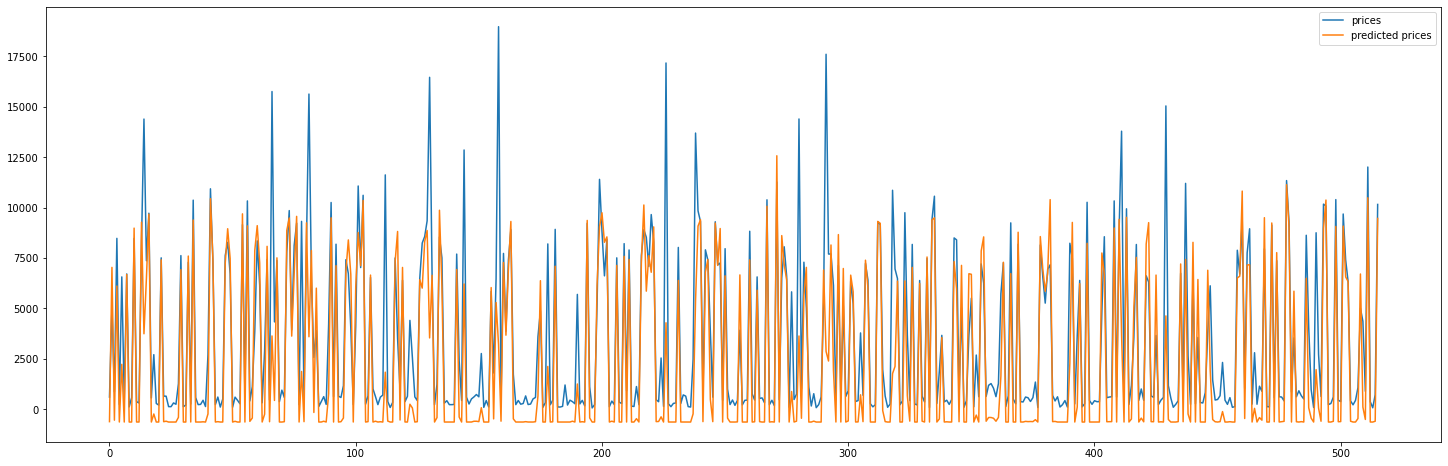

In [62]:
temp = Y_test_reg.to_numpy()
temp

plt.figure(figsize=(25,8))
plt.plot(temp, label = 'prices')
plt.plot(y_pred_pca, label = 'predicted prices' )
plt.legend()
plt.show()

### RF

In [63]:
svr_rf = SVR(kernel='rbf',C=10000,verbose=True)
svr_rf.fit(X_train_reg_rf,Y_train_reg)
svr_rf.score(X_train_reg_rf,Y_train_reg), svr_rf.score(X_test_reg_rf,Y_test_reg)

[LibSVM]

(0.8339009804630496, 0.8048499577093173)

In [64]:
y_pred_rf = svr_rf.predict(X_test_reg_rf)
print( 'MAE : ', mean_absolute_error(Y_test_reg,y_pred_rf) )
print( 'MSE : ' , mean_squared_error(Y_test_reg,y_pred_rf) )
print( 'RMSE :', np.sqrt(mean_squared_error(Y_test_reg,y_pred_rf)) )
print( 'MAPE : ' , mean_absolute_percentage_error(Y_test_reg,y_pred_rf) )

MAE :  807.6364782812183
MSE :  3113392.8836513297
RMSE : 1764.4809105375239
MAPE :  32.97927625132353


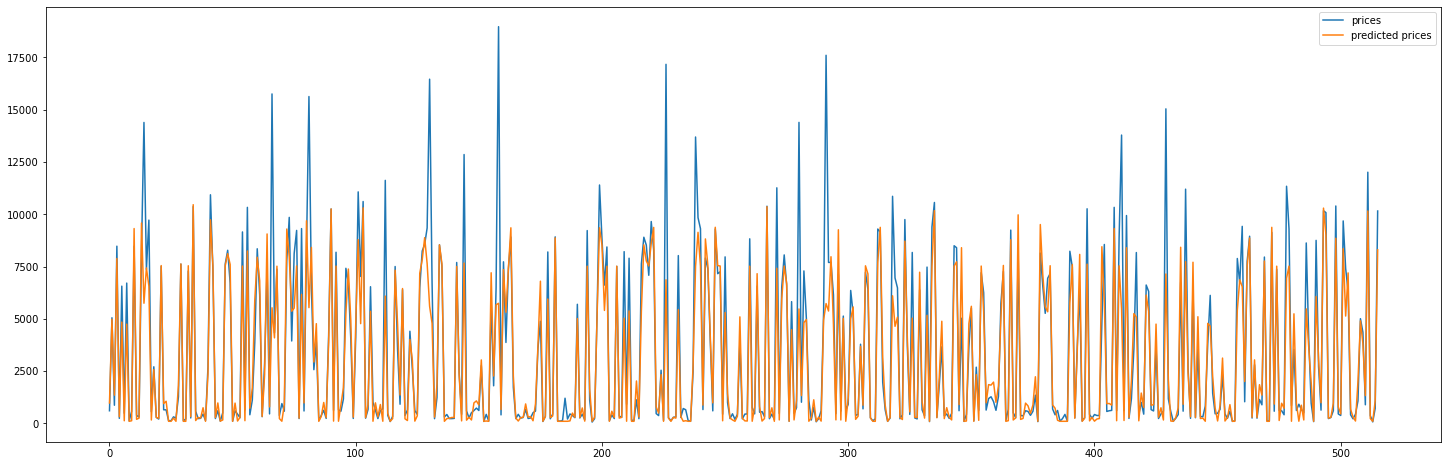

In [65]:
plt.figure(figsize=(25,8))
plt.plot(temp, label = 'prices')
plt.plot(y_pred_rf, label = 'predicted prices' )
plt.legend()
plt.show()

# LSTM Classification

In [ ]:
from tensorflow import keras

In [ ]:
from keras import *
from keras.callbacks import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from keras.layers import *

In [ ]:
from keras.optimizer_v2.adam import Adam as Adam

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def transform_y(y):
    y=y.values
    unique1, id1 = np.unique(y_train, return_inverse=True)
    

In [ ]:
unique1, id1 = np.unique(Y_train_class, return_inverse=True)
y_train=to_categorical(id1,num_classes=2)

### PCA

In [ ]:
X_train=np.reshape(X_train_class_pca,(X_train_class_pca.shape[0],1,X_train_class_pca.shape[1]))
X_test=np.reshape(X_test_class_pca,(X_test_class_pca.shape[0],1,X_test_class_pca.shape[1]))
unique1, id1 = np.unique(Y_train_class.values, return_inverse=True)
y_train=to_categorical(id1,num_classes=2)

In [ ]:
#X_train = X_train_class_pca
#X_test = X_test_class_pca

In [ ]:
adam=Adam(lr=lr_schedule(0),amsgrad=True)

model = Sequential()
model.add(Bidirectional(LSTM(80, return_sequences=True, activation='relu'), input_shape=(1,X_train.shape[-1])))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
#model.add(Bidirectional(LSTM(40, return_sequences=True, activation='relu')))
model.add(Dense(1,activation='softmax'))
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])

mcp_save = ModelCheckpoint('test', save_best_only=True, monitor='val_loss', mode='max')
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='max')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train,y_train, epochs=1500, batch_size=32, validation_split=0.1,validation_freq=1,
          shuffle=False,use_multiprocessing=True, callbacks=[mcp_save,earlyStopping])

In [ ]:
prediction_model = load_model('test',compile=False)
y_pred = model(X_test)
y_pred = y_pred.numpy()[:,0,0]

In [ ]:
print('Accuracy score : ', accuracy_score(Y_test_class,y_pred) )
print( 'f1 score : ', f1_score(Y_test_class,y_pred,average='binary'))
print( 'AUC : ', roc_auc_score(Y_test_class,y_pred))
print(classification_report(Y_test_class,y_pred,labels=[0,1], target_names=['decrease','increase']))

## RF

In [ ]:
X_train_class_rf.to_numpy().reshape( (X_train_class_rf.shape[0],1,X_train_class_rf.shape[-1]) )

In [ ]:
X_train = X_train_class_rf.to_numpy().reshape( (X_train_class_rf.shape[0],1,X_train_class_rf.shape[-1]) )
X_test=np.reshape(X_test_class_rf.to_numpy(),(X_test_class_rf.shape[0],1,X_test_class_rf.shape[-1]))
unique1, id1 = np.unique(Y_train_class.values, return_inverse=True)
y_train=to_categorical(id1,num_classes=2)

In [ ]:
adam=Adam(lr=lr_schedule(0),amsgrad=True)

model = Sequential()
model.add(Bidirectional(LSTM(80, return_sequences=True, activation='relu'), input_shape=(1,X_train.shape[-1])))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
#model.add(Bidirectional(LSTM(40, return_sequences=True, activation='relu')))
model.add(Dense(1,activation='softmax'))
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])

mcp_save = ModelCheckpoint('test', save_best_only=True, monitor='val_loss', mode='max')
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='max')

In [ ]:
model.fit(X_train,y_train, epochs=1500, batch_size=32, validation_split=0.1,validation_freq=1,
          shuffle=False,use_multiprocessing=True, callbacks=[mcp_save,earlyStopping])

In [ ]:
prediction_model = load_model('test',compile=False)
y_pred = model(X_test)
y_pred = y_pred.numpy()[:,0,0]

In [ ]:
print('Accuracy score : ', accuracy_score(Y_test_class,y_pred) )
print( 'f1 score : ', f1_score(Y_test_class,y_pred,average='binary'))
print( 'AUC : ', roc_auc_score(Y_test_class,y_pred))
print(classification_report(Y_test_class,y_pred,labels=[0,1], target_names=['decrease','increase']))

# LSTM Regression 

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

### PCA

In [ ]:
X_train=np.reshape(X_train_reg_pca,(X_train_reg_pca.shape[0],1,X_train_reg_pca.shape[1]))
X_test=np.reshape(X_test_reg_pca,(X_test_reg_pca.shape[0],1,X_test_reg_pca.shape[1]))
y_train=Y_train_reg.values
y_train=np.reshape(y_train, (y_train.shape[0],1,1))
y_test=Y_test_reg.values
y_test=np.reshape(y_test,(y_test.shape[0],1,1))

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
model.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
model.add(Dense(1))
model.compile(loss="logcosh", optimizer=adam, metrics=['mae'])

mcp_save = ModelCheckpoint('test2', save_best_only=True, monitor='val_loss', mode='auto')
earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

In [ ]:
model.fit(X_train,y_train, epochs=3, batch_size=32, validation_data=(X_test,y_test), 
          callbacks=[mcp_save,earlyStopping])

In [ ]:
prediction_model = load_model('test2',compile=False)

y_pred = np.ravel(prediction_model.predict(X_test.reshape(X_test.shape[0],X_test.shape[-1])))
y_test=np.ravel(y_test)

In [ ]:
print( '$r^2$ score : ', r2_score(y_test,y_pred))
print( 'MAE : ', mean_absolute_error(y_test,y_pred) )
print( 'MSE : ' , mean_squared_error(y_test,y_pred) )
print( 'RMSE :', np.sqrt(mean_squared_error(y_test,y_pred)) )
print( 'MAPE : ' , mean_absolute_percentage_error(y_test,y_pred) )

# References 

### Scrapping 
https://github.com/rohansawant7978/bitcoin-price-forecasting

### Augmented Dickey-Fuller
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#




model ???

https://github.com/heliphix/btc_data

a classer


https://github.com/sergiovirahonda/AnomalyDetection/blob/main/Bitcoin/Notebook/forecasting-and-anomally-detection.ipynb


https://github.com/jaskirat111/Bitcoin-Time-Series-Forecast-ML-System


https://github.com/Pranjal-26/Time-series-Forecasting---TensorFlow/blob/main/Final_project%20(1).ipynb

https://github.com/Ashishkutchi/capstone-w2020-t2-g03-Time-Series-Forecasting-of-Bitcoin-Price

https://github.com/AmalVijayan/Time-Series-Forecasting---Predicting-Bitcoin-Prices

# TO DO 

### Scrap data used by the article 
Check if everything is scrapped

Remove NaN values ✅

### Preprocess data 
linear interpolation to have missings cases // j'arrive pas à fill les nan values 
autrement qu'avec une rolling mean --> df.interpolate() marche pas

create train test data ✅

### Visualisation 
pca ✅

voir ce qu'on peut faire avec le PCA

correlation between features

#### cohérence avec l'article
comprendre/essayer de plot la figure 4 --> jsp d'ou elle sort

### feature selection
essayer de retrouver ceux de l'article table 3 ou du github 

utiliser VIF ou pearson pour la multicolinéarité

mettre au propre la partie relative au TP // comprendre pourquoi on a pas les mêmes features que l'article/github et que notre code à la fin de la partie pre)-

## Pour plus tard

### Improvement 
Test on new datas --> avg block time --> must take more time 

# Remarks 

Generally, the missing values are the number of tweets --> difficult to approximate